# compose visualisations of listerner experience paper

In [35]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import librosa
from IPython.display import Audio
import mir_eval.sonify
from pydub import AudioSegment
from matplotlib.transforms import ScaledTranslation


from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [219]:
!pip list

Package                       Version
----------------------------- -----------
aa-test-package               0.0.8
alabaster                     0.7.12
appdirs                       1.4.4
appnope                       0.1.0
argon2-cffi                   20.1.0
async-generator               1.10
attrs                         20.3.0
audioread                     2.1.9
Babel                         2.9.0
backcall                      0.2.0
bcrypt                        4.0.1
beautifulsoup4                4.9.3
bleach                        3.2.1
bokeh                         3.1.1
build                         0.10.0
certifi                       2020.6.20
cffi                          1.14.3
chardet                       3.0.4
charset-normalizer            3.2.0
click                         7.1.2
cmake                         3.27.5
colorama                      0.4.4
contourpy                     1.0.7
cryptography                  39.0.2
cycler                        0.10.0
Cython   


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al
%aimport eq
%aimport rp2
%aimport mh

In [3]:
 %reload_ext autoreload

In [4]:
def Part_maps(Entries):
    parts_on = {}
    cols = Entries.columns
    for c in cols:
        if Entries[c].isna().sum()>1:
            Entries.loc[Entries[c].notna(),['mm',c]]
            V = Entries.loc[Entries[c].notna(),['mm',c]]
            parts_on[c]=V.rename(columns = {c:'Playing'})
            D = pd.DataFrame(index = parts_on[c].index )
            for i in D.index:
                if parts_on[c].loc[i,'Playing'] == 1.0:
                    D[i] = D.index-i
            D[D>=0] = np.nan
            D['Pre'] = D.max(axis=1)
            D.loc[parts_on[c].loc[:,'Playing'] == 1.0,'Pre'] = 0.0
            parts_on[c]['Pre'] = D['Pre']
            parts_on[c]['Post'] = parts_on[c]['Pre'].diff()
            parts_on[c].loc[parts_on[c]['Post']<=0,'Post'] = 0.0
            parts_on[c][parts_on[c].isna()] = 0.0
    return parts_on
def resp_shade(ax,breaths,cat,colour):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Period_T'], facecolor=colour,alpha = 0.2)
    return

def resp_shaded(ax,breaths,cat,colour,alph = 0.4):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Insp_T'], facecolor=colour,alpha = alph )
        ax.axvspan(r['Ex'],r['Ex']+r['Exp_T'], facecolor=colour,alpha = alph - 0.2)
    return

def quickcarresp(Breaths):
    Insp_seq = Breaths.copy()#.query('In > @xlim[0] and In < @xlim[1]').copy().reset_index(drop=True)
    Insp_seq.loc[:,'dPT'] = np.log(Insp_seq['Period_T']/Insp_seq['Period_T'].shift(1)).abs()
    Insp_seq.loc[:,'dIT'] = np.log(Insp_seq['Insp_T']/Insp_seq['Insp_T'].shift(1)).abs()
    Insp_seq.loc[:,'dID'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].shift(1)).abs()
    Insp_seq.loc[:,'relD'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].rolling(5,center=True).median()).abs()
    
    depth_thresh = Insp_seq['IDepth'].median()*2
    low_D =  Insp_seq['IDepth'].quantile(0.25)
    mD =  Insp_seq['IDepth'].median()
    mT =  Insp_seq['Period_T'].median() 
    mIT =  Insp_seq['Insp_T'].median()
    
    Insp_seq['Categories']='Disturbed'

    V =  Insp_seq.query('Insp_T>0.5 and Period_T>2 and IDepth<3*@low_D and IE_Ratio>0.2 and dPT<0.5 and dID<0.5')
    Insp_seq.loc[V.index,'Categories']='Quiet'
    
    return Insp_seq

In [5]:
respcats = ['Disturbed','Quiet']

## KORK data

In [9]:
# audio file locations in
baseDir = '/Users/finn/Desktop/Current_Projects/KORK/Data/'
phys_loc = '../KORK/Signals/'
audio_loc =  baseDir + 'Audio/Pieces/'
timing_loc = baseDir + 'Timing/'
c = 'C1'
piece = 'Sae1'
# F = pd.read_csv(timing_loc+'PlayTimings_KORK2024_'+piece+'.csv')
F = pd.read_csv(timing_loc+'KORK2024_events - C1_events.csv')
F['Performance'] = c
Event_timings = F
Event_timings['Duration_s'] = Event_timings['c_sTime'].diff().shift(-1)
PartDets = pd.read_csv( baseDir + 'Participants/Participant_Metadata.csv',index_col = 0)
player_order = list(PartDets.index)
Dets=PartDets.loc[player_order,['Section', 'Instrument','Part']].copy()
mydpi = 196

In [176]:
key_annotations.index
np.arange(0,30)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [181]:
piece = 'Sae1'
Pentries = pd.read_csv(timing_loc+'PlayTimings_KORK2024_'+piece+'.csv')
Pstructures = Pentries.loc[Pentries['Structure'].notna(),:]
Pstructures 
Pthemes = Pentries.loc[Pentries['Theme'].notna(),:]
Pthemes
Prehearse = Pentries.loc[Pentries['RehNo'].notna(),:]
Prehearse
# annotations = pd.read_csv('./infiles/K1_Saev_AU815_Notes.csv')
annotations = pd.read_csv(phys_loc+'C1_Sae1_AU815_annotations.csv')
key_annotations = pd.read_csv(phys_loc+'C1_Sae1_AU815_densenotes.csv')
QOM_key_annotations = key_annotations.loc[[16,17,26,27],:].copy()
Resp_key_annotations = key_annotations.loc[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       18, 19, 20, 21, 22, 23, 24, 25,  28, 29, 30],:].copy()
annotations
Psustains = pd.read_csv(baseDir+'Audio/Annotations/'+'sustained_k1.csv')
Pentries
key_annotations

,TIME,LABEL
0,28.908844,m 6 hold
1,34.202993,m 7 hold
2,35.596190,Co-exp C A1
3,39.357823,m 8
4,41.671111,m 8.5 co-exp A1 A2
5,49.554286,m 10 co-insp C A1
6,54.430476,m 11 hold
7,56.482540,m 11.5 co exp C A1
8,89.864127,m 18 hold
9,96.690794,m 19.25 fanfar


In [105]:
# Sensor measurements

os.listdir('../KORK/Signals/')
dfeats = {}
Breathings = {}
for rec in ['AU815_Saev1','AU815_Saev2','VN101_Saev1']:
    dfeats[rec] = pd.read_csv('../KORK/Signals/'+rec+'_Feats.csv',index_col=0)
    if rec.endswith('2'):
        dfeats[rec].set_index('Time_1',inplace=True)
    Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(dfeats[rec].loc[:,'Resp_wave']),dfeats[rec].loc[:,'Resp_wave'])
    Insp_seq = quickcarresp(Breaths)
    Breathings[rec] = quickcarresp(Breaths).copy()
    R = (dfeats[rec].loc[:,'Resp_wave']-dfeats[rec].loc[:,'Resp_wave'].median())/Insp_seq['IDepth'].quantile(0.15)
    dfeats[rec].loc[:,'Resp_wave'] = R
dfeats.keys()

dict_keys(['AU815_Saev1', 'AU815_Saev2', 'VN101_Saev1'])

['VN101_Saev1', 28.390510917953154]
['AU815_Saev1', 11.957261164524061]
['AU815_Saev2', 11.931625481362149]


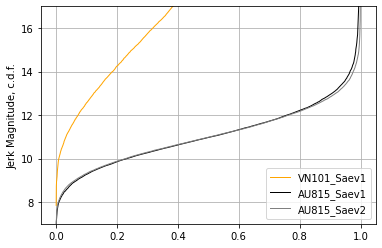

In [94]:
buff = 0
s_time = -buff
e_time = dur+buff
# C_df.loc[s_time:e_time,:]
# fig3 = plt.figure(constrained_layout=True,figsize=(8.5,8))
for rec in recs:
    print ([rec,dfeats[rec].loc[s_time:e_time,'Jerk'].quantile(.75)])
    C = pd.Series(dfeats[rec].loc[s_time:e_time,'Jerk']).sort_values().reset_index(drop=True)
    C.index = C.index/len(C)
    C.plot(linewidth=1,c=PartPalette[rec],label = rec)
plt.legend()
plt.ylabel('Jerk Magnitude, c.d.f.')
plt.grid()
plt.ylim([7,17])
plt.show()

In [97]:
# Event
e_i = 19 # 75
ev = Event_timings.loc[e_i,:].copy()
piece = ev['Related']
if ev['Related'].startswith('Sae'):
    ev['Duration_s']  += Event_timings.loc[e_i+1,'Duration_s']
dur = ev['Duration_s']

In [98]:
# Audio recording and features
buff = 10
aud_file = audio_loc +'C1_' + ev["Related"]+'_10.mp3' #C1_Sae1_1.mp3
y, sr = librosa.load(aud_file)
rms =librosa.feature.rms(y=y, frame_length=256, hop_length=64, center=True, pad_mode='constant')
times = librosa.times_like(rms,sr = sr, hop_length=64)
rms_sf = int(sr/64)
aud_df = pd.DataFrame(index = times-buff ) # + M_times.loc[segtag,'Start']
aud_df['rms'] = rms[0]

C = librosa.cqt(y=y, sr=sr)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
times = (-buff+np.arange(len(C_db[0]))*(2*buff+dur)/len(C_db[0])).round(3)
pitchticks = np.arange(7,84,12)
pitchticklabels=['C1','C2','C3','C4','C5','C6','C7']
C_df = pd.DataFrame(data=C_db).transpose()
C_df = C_df[C_df.columns[::-1]]
C_df.set_index(times,inplace = True)

In [99]:
# labelse and categories
palettes = ['c','m','g','r','b','k']
player = 'AU815'
respcats = ['Disturbed','Quiet']
palette={'Disturbed':'c','Quiet':'lightblue'}
PartPalette = {'AU815_Saev1':'k','AU815_Saev2':'grey','VN101_Saev1':'orange'}
pitchticks = np.arange(7,84,12)
pitchticklabels=['C1','C2','C3','C4','C5','C6','C7']

In [168]:
buff = 10
s_time = -buff
e_time = dur+buff
C_df.loc[s_time:e_time,:]

,83,82,81,80,79,78,77,76,75,74,...,9,8,7,6,5,4,3,2,1,0
-10.000,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.977,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.954,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.930,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.907,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470.336,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
470.359,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
470.382,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
470.405,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0


In [101]:
frameN = len(C_df.loc[s_time:e_time,:])

# np.linspace(0, frameN - 1,frameN,dtype='int')
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
xticks = f(Pstructures.loc[:,'C1_Sae1'])
xticklabels = Pstructures.loc[:,'Structure']

16-17-18
          TIME                                            LABEL
0    30.023401                                     6.2 2s pause
1    34.969252                                     7.2 2s pause
2    41.726259                                 8.5 basses cresc
3    55.379592                                    11.2 2s pause
4    56.459320                                    11.5 2s pause
5    59.001905                                    12.1 2s pause
6    60.383492                                      12.45 onset
7    69.601814                             14.0 subtle downbeat
8    71.401361                                       14.5 onset
9   109.133787             21.5 ish, slow scattered cue cue cue
10  132.469841               27.0 celli first tremolo, momentum
11  133.561179                              27.25 end of phrase
12  153.396825                                   33.0 new tempo
13  153.965714                33.25 new tempo cue upper strings
14  162.377143                 

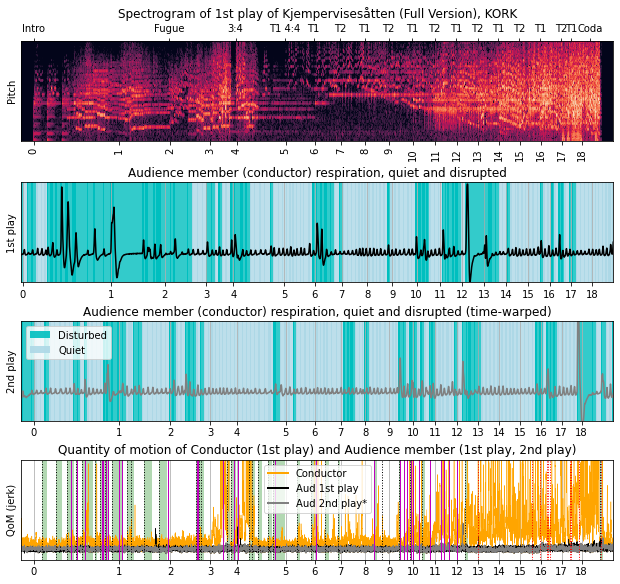

In [182]:
fig3 = plt.figure(constrained_layout=True,figsize=(8.5,8))
gs = fig3.add_gridspec(4, 3)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
axes[1] = fig3.add_subplot(gs[1, :])
axes[2] = fig3.add_subplot(gs[2, :])
axes[3] = fig3.add_subplot(gs[3, :])

buff=10
resprange = [-7,18]
s_time = -buff #C_times.loc[0,concert]
e_time = dur+buff

ax=axes[0]
ax.set(title='Spectrogram of 1st play of Kjempervisesåtten (Full Version), KORK') # with Rehearsal numbers and Structure
chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
ax.set(xticks = f(Prehearse.loc[:,'C1_Sae1']),xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.set(yticks=[],ylabel='Pitch') 
ax1 = ax.twiny()
ax1.set(xticks=Pstructures.loc[:,'C1_Sae1'],xticklabels=Pstructures.loc[:,'Structure'],xlim=[s_time,e_time])

# chart.set_yticks([83,71,59,47,35,23,11])
# chart.set_yticklabels(pitchticklabels)
# ax1.set(xticks = Pthemes.loc[:,'C1_Sae1'],xticklabels=Pthemes.loc[:,'Theme'])

ax=axes[1]
df_feats = dfeats['AU815_Saev1'].copy()
Insp_seq = Breathings['AU815_Saev1'].copy()
df_feats.loc[:,'Resp_wave'].plot(c=PartPalette['AU815_Saev1'],linestyle='-',label="",ax = ax)
ax.set_xlim([s_time,e_time])
for cat in respcats: #'Vocal?',
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[-1,dur+1],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
ax.set(title='Audience member (conductor) respiration, quiet and disrupted',ylabel='1st play')


ax=axes[2]
df_feats = dfeats['AU815_Saev2'].copy()
Insp_seq = Breathings['AU815_Saev2'].copy()
df_feats.loc[:,'Resp_wave'].plot(c=PartPalette['AU815_Saev2'],linestyle='-',label="",ax = ax)
for cat in respcats: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
ax.legend(loc='upper left')
for cat in respcats:
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
# ax.set(xticks = Pthemes.loc[:,'C1_Sae1'],xticklabels=Pthemes.loc[:,'Theme'])
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
ax.set(title='Audience member (conductor) respiration, quiet and disrupted (time-warped)',ylabel='2nd play')

ax=axes[3]
recs = ['VN101_Saev1','AU815_Saev1','AU815_Saev2',]
recs_labels = {'VN101_Saev1':'Conductor','AU815_Saev1':'Aud 1st play','AU815_Saev2':'Aud 2nd play*',}
for rec in recs:
    df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],linewidth=2,label = recs_labels[rec],ax = ax)
ax.legend(loc='upper left')

for rec in recs:
    df_feats = dfeats[rec].copy()
    df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],linewidth=0.5,ax = ax)
ax.set(ylim=[0,100],xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
for i,row in Psustains.iterrows():
    ax.axvspan(row['TIME'],row['TIME']+row['DURATION'], facecolor='g',alpha = 0.3)
    ax.plot([row['TIME'],row['TIME']],[0,100],linestyle = ':',linewidth=1,color='k')  
ax.set(title = 'Quantity of motion of Conductor (1st play) and Audience member (1st play, 2nd play)', ylabel = 'QoM (jerk)')

tcue_list = annotations.query('TIME<@e_time and TIME>@s_time')
print(exc)
print(tcue_list)
for tcue in annotations.loc[tcue_list.index,'TIME']:
    ax.plot([tcue, tcue],[0,100],linestyle = ':',linewidth=1,color='red')  
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[],yticklabels=[]) #,ylabel='Resp'

tcue_list = key_annotations.query('TIME<@e_time and TIME>@s_time')
print(exc)
print(tcue_list)
for tcue in annotations.loc[tcue_list.index,'TIME']:
    ax.plot([tcue, tcue],[0,100],linestyle = '-',linewidth=1,color='m')  
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[],yticklabels=[]) #,ylabel='Resp'


outplots = './plots/'
figname = '_'.join(['Compound_Full',player,ev['Event']+'_1.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()

In [183]:
#Psustains

In [216]:
piece = 'Sae1'
Pentries = pd.read_csv(timing_loc+'PlayTimings_KORK2024_'+piece+'.csv')
Pstructures = Pentries.loc[Pentries['Structure'].notna(),:]
Pstructures 
Pthemes = Pentries.loc[Pentries['Theme'].notna(),:]
Pthemes
Prehearse = Pentries.loc[Pentries['RehNo'].notna(),:]
Prehearse
# annotations = pd.read_csv('./infiles/K1_Saev_AU815_Notes.csv')
annotations = pd.read_csv(phys_loc+'C1_Sae1_AU815_annotations.csv')
key_annotations = pd.read_csv(phys_loc+'C1_Sae1_AU815_densenotes.csv')
QOM_key_annotations = key_annotations.loc[[16,17,26,27],:].copy()
# Resp_key_annotations = key_annotations.loc[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
#        18, 19, 20, 21, 22, 23, 24, 25,  28, 29, 30],:].copy()
Resp_key_annotations = key_annotations.loc[[ 0, 2, 5,  7,  8,  9, 11, 13, 15,
       18, 20, 21, 22, 23, 24, 25,  28, 29, 30],:].copy()

annotations
Psustains = pd.read_csv(phys_loc+'C1_Sae1_AU815_sustains.csv')
Pentries
# Resp_key_annotations

,S_1,RehNo,Structure,Theme,mm,Conductor,Flute_1,Flute_2,Oboe_1,Oboe_2,...,Va_solo,Viola,Vc_Solo,Cello,Contrabass,C1_Sae1,C1_Sae2,RD_Sae1,RD_Sae2,RR_Saev
0,1.019501,0.0,Intro,NaN,1.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.019501,0.019501,0.019501,-0.003900,-0.003900
1,2.539683,NaN,NaN,a,1.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.539683,1.726893,1.539683,1.492880,1.492880
2,9.204535,NaN,NaN,NaN,2.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.204535,8.181134,7.572698,6.917460,6.543039
3,12.078730,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.078730,10.470295,9.885261,9.300227,9.230023
4,13.670748,NaN,NaN,a,3.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.670748,12.038912,11.407075,10.634830,10.822041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,456.787302,NaN,NaN,NaN,160.75,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,455.787302,442.986757,446.169342,425.318730,412.658594
208,457.227030,NaN,NaN,NaN,161.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,456.227030,443.426485,446.609070,425.758458,413.098322
209,458.109388,NaN,NaN,NaN,161.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,457.109388,444.285442,447.468027,426.594014,413.910476
210,459.067211,NaN,NaN,NaN,162.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,458.067211,445.243265,448.425850,427.551837,414.868299


0-1 Slow introduction 
        TIME               LABEL
0  28.908844            m 6 hold
2  35.596190         Co-exp C A1
5  49.554286   m 10 co-insp C A1
7  56.482540  m 11.5 co exp C A1
Empty DataFrame
Columns: [TIME, LABEL]
Index: []
2-4 Fugue and Meter change
          TIME                         LABEL
11  133.384127        m 27.25 co exp C A1 A2
13  153.986032  m 33.25 offbeat tutti accent
15  163.230476            m 36.5 co exp C A1
          TIME                       LABEL
16  165.566984  37.167 viola/harp/clarinet
17  168.086349  38.167 viola/harp/clarinet
4-6 into Solo, Soli T1
          TIME                LABEL
18  227.393016   m 58.75 viola soli
20  230.278095  m 59.67 co exp C A1
Empty DataFrame
Columns: [TIME, LABEL]
Index: []
8-10 Violin T1 Oboe T2
          TIME                      LABEL
21  297.076100  m 86.25 co inso C A2 Oboe
22  306.651429   m 90.25 co ins C A2 Oboe
Empty DataFrame
Columns: [TIME, LABEL]
Index: []
11-14 marc. e pesante to marcato agitato
        

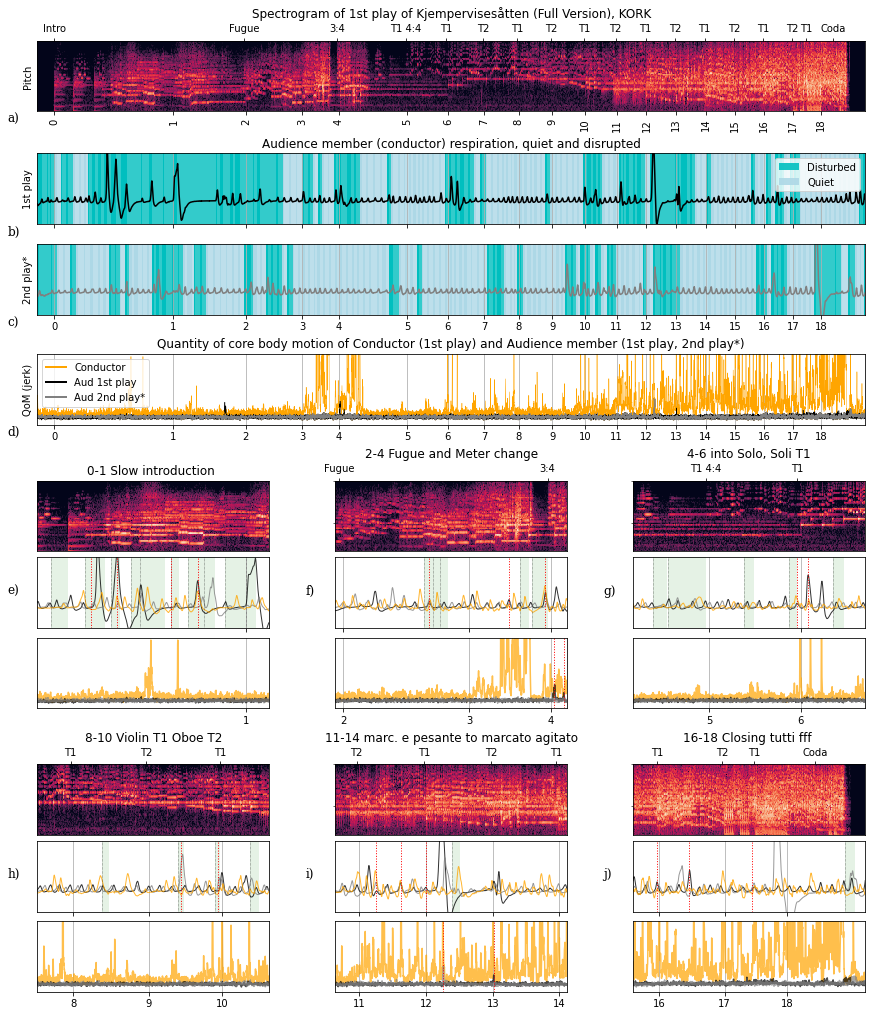

In [218]:
fig3 = plt.figure(constrained_layout=True,figsize=(12,14))
gs = fig3.add_gridspec(10, 3)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
axes[1] = fig3.add_subplot(gs[1, :])
axes[2] = fig3.add_subplot(gs[2, :])
axes[3] = fig3.add_subplot(gs[3, :])
axes[4] = fig3.add_subplot(gs[4,0])
axes[5] = fig3.add_subplot(gs[5,0])
axes[6] = fig3.add_subplot(gs[6,0])
axes[7] = fig3.add_subplot(gs[4,1])
axes[8] = fig3.add_subplot(gs[5,1])
axes[9] = fig3.add_subplot(gs[6,1])
axes[10] = fig3.add_subplot(gs[4,2])
axes[11] = fig3.add_subplot(gs[5,2])
axes[12] = fig3.add_subplot(gs[6,2])
axes[13] = fig3.add_subplot(gs[7,0])
axes[14] = fig3.add_subplot(gs[8,0])
axes[15] = fig3.add_subplot(gs[9,0])
axes[16] = fig3.add_subplot(gs[7,1])
axes[17] = fig3.add_subplot(gs[8,1])
axes[18] = fig3.add_subplot(gs[9,1])
axes[19] = fig3.add_subplot(gs[7,2])
axes[20] = fig3.add_subplot(gs[8,2])
axes[21] = fig3.add_subplot(gs[9,2])

buff=10
resprange = [-7,15]
s_time = -buff
e_time = dur+buff

ax=axes[0]
chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
ax.set(xticks = f(Prehearse.loc[:,'C1_Sae1']),xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.set(yticks=[],ylabel='Pitch') 
ax1 = ax.twiny()
ax1.set(xticks=Pstructures.loc[:,'C1_Sae1'],xticklabels=Pstructures.loc[:,'Structure'],xlim=[s_time,e_time])
ax.set(title='Spectrogram of 1st play of Kjempervisesåtten (Full Version), KORK') # with Rehearsal numbers and Structure

ax=axes[1]
df_feats = dfeats['AU815_Saev1'].copy()
Insp_seq = Breathings['AU815_Saev1'].copy()
df_feats.loc[:,'Resp_wave'].plot(c=PartPalette['AU815_Saev1'],linestyle='-',label="",ax = ax)
ax.set_xlim([s_time,e_time])
for cat in respcats: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
ax.legend(loc='upper right') #loc='upper right'
for cat in respcats: #'Vocal?',
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[-1,dur+1],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=[],xlim=[s_time,e_time])
ax.grid()
ax.set(title='Audience member (conductor) respiration, quiet and disrupted',ylabel='1st play')

ax=axes[2]
df_feats = dfeats['AU815_Saev2'].copy()
Insp_seq = Breathings['AU815_Saev2'].copy()
df_feats.loc[:,'Resp_wave'].plot(c=PartPalette['AU815_Saev2'],linestyle='-',label="",ax = ax)
for cat in respcats: 
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
# ax.legend() #loc='upper right'
for cat in respcats:
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
ax.set(title='',ylabel='2nd play*') #Audience member (conductor) respiration, quiet and disrupted (time-warped)

ax=axes[3]
recs = ['VN101_Saev1','AU815_Saev1','AU815_Saev2',]
recs_labels = {'VN101_Saev1':'Conductor','AU815_Saev1':'Aud 1st play','AU815_Saev2':'Aud 2nd play*',}
for rec in recs:
    df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],linewidth=2,label = recs_labels[rec],ax = ax)
ax.legend(loc='upper left')
for rec in recs:
    df_feats = dfeats[rec].copy()
    df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],linewidth=0.5,ax = ax)
ax.set(ylim=[0,100],xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
ax.set(title = 'Quantity of core body motion of Conductor (1st play) and Audience member (1st play, 2nd play*)', ylabel = 'QoM (jerk)')

resprange = [-5,12]

intervals={
"0-1 Slow introduction ":[15,75],
"2-4 Fugue and Meter change":[109,169],
"4-6 into Solo, Soli T1":[185,245],
"8-10 Violin T1 Oboe T2":[260,320],# "m 107, m 115":[342,362],
"11-14 marc. e pesante to marcato agitato":[320,380],# "m 107, m 115":[342,362],
"16-18 Closing tutti fff ":[405,465]}


excerpts_Label=list(intervals.keys())
for i in range(len(intervals)):
    exc = excerpts_Label[i]
    [s_time,e_time] = intervals[exc]
    
    ax = axes[(i*3)+4]
    chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
    ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Audio'
    ax1 = ax.twiny()
    ax1.set(xticks=Pstructures.loc[:,'C1_Sae1'],xticklabels=Pstructures.loc[:,'Structure'],xlim=[s_time,e_time])
    ax.set_title(exc)

    ax = axes[(i*3)+5]
    recs = ['AU815_Saev1','AU815_Saev2','VN101_Saev1']
    PartStyle = {'AU815_Saev1':1,'AU815_Saev2':1,'VN101_Saev1':1}

    for rec in recs:
        df_feats = dfeats[rec].copy()
        df_feats.loc[:,'Resp_wave'].plot(c=PartPalette[rec],linewidth = PartStyle[rec],label = rec,alpha=0.8,ax = ax) 
    ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Resp'
    subSus = Psustains.query('TIME<@e_time and TIME>@s_time').copy()
    if len(subSus)>0:
        for j,row in subSus.iterrows():
            ax.axvspan(row['TIME'],row['TIME']+row['DURATION'], facecolor='g',alpha = 0.1)
            ax.plot([row['TIME'],row['TIME']],resprange,linestyle = ':',linewidth=0.5,color='k')  
    tcue_list = Resp_key_annotations.query('TIME<@e_time and TIME>@s_time')
    print(exc)
    print(tcue_list)
    for tcue in Resp_key_annotations.loc[tcue_list.index,'TIME']:  ax.plot([tcue, tcue],resprange,linestyle = ':',linewidth=1,color='r')  
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=resprange)
    ax.grid()
    
    recs = ['VN101_Saev1','AU815_Saev1','AU815_Saev2']
    ax = axes[(i*3)+6]
    for rec in recs:
        df_feats = dfeats[rec].copy()
        df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],label = rec,alpha = 0.7,ax = ax)
    tcue_list = QOM_key_annotations.query('TIME<@e_time and TIME>@s_time')
    print(tcue_list)
    for tcue in QOM_key_annotations.loc[tcue_list.index,'TIME']:  ax.plot([tcue, tcue],[0,100],linestyle = ':',linewidth=1,color='r')  
    ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[],yticklabels=[]) #,ylabel='Resp'
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=[0,100])
    ax.grid()
    
ax_labels = ['a)','b)','c)','d)','','e)','','','f)','','','g)','','','h)','','','i)','','','j)','','','k)','','']
for i in range(len(axes)):
    ax = axes[i]
    label = ax_labels[i]
    if i<4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -85/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
    if i>=4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -40/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')

outplots = './plots/'
figname = '_'.join(['Compound_Excerpts',player,ev['Event']+'_3.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()

In [27]:
intervals={
"Slow intro, 1 ":[0,60],
"1-3":[90,150],
"3-6":[185,245],
"6-10":[250,310],# "m 107, m 115":[342,362],
"12-14":[320,380],# "m 107, m 115":[342,362],
"16-17-18":[410,470]}

intervals={
"Slow intro, 1-2 ":[0,60],
"3-4":[60,120],
"4-5":[120,180],
"4-6":[180,240],
"9-10":[240,300],# "m 107, m 115":[342,362],
"12-14":[300,360],# "m 107, m 115":[342,362],
} #"16-17-18":[410,470]


tcue_list = [8,13,18]
lowpart_downbeatACCphrase = [6,7,9,10,11,12,14] #6,7 # ,14,15,16 20,25
entry_melody = [19,21] 
norest_list = [22,23,26,28]
for tcue in annotations.loc[tcue_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold')   
for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
for tcue in annotations.loc[entry_melody,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
for tcue in annotations.loc[norest_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')


    
# Slow intro, 1-2 
#         TIME             LABEL
# 0  30.023401      6.2 2s pause
# 1  34.969252      7.2 2s pause
# 2  41.726259  8.5 basses cresc
# 3  55.379592     11.2 2s pause
# 4  56.459320     11.5 2s pause
# 5  59.001905     12.1 2s pause
# 3-4
#           TIME                         LABEL
# 10  132.469841  27.0 celli tremolo, momentum
# 4-6
#           TIME                                            LABEL
# 15  194.194286                                46.667 long pause
# 16  195.697778                      47.0 downbeat through pause
# 17  229.627937  59.5 tutti viola characteristic slurred leap up
# 9-10
#           TIME                               LABEL
# 18  276.398730                     78.0 phrase end
# 19  297.029660  86.5 breath between phrases (oboe)
# 20  297.772698              86.75 phrase two onset
# 12-14
#           TIME                                       LABEL
# 21  306.596281                        90.5 breath between 
# 22  307.664399                     91.0 alto cello preciso
# 23  312.772789                     93.0 alto cello preciso
# 24  321.584762  97.0 cue breath for trumpet at 97.25 entry
# 25  330.570884                                      101.0 
# 26  333.450159                           102.5 phrase puse
# 27  336.909932                                       104.0
# 28  343.486984                           107.0 Now lyrical
# 16-17-18
#           TIME                                   LABEL
# 31  411.132517    138.75 pick up to all strings melody
# 32  416.380227                        141.5 lead into 
# 33  417.541224                 141.75  into phrase end
# 34  419.445261                        142.75 ff pickup
# 35  435.606349                   150.5 prepare for 151
# 36  436.581587  151.0  fff fs lower strings descending
# 37  442.479456      154.0 long end of phrase before 18
# 38  460.678095                        163.0 music over

intervals={
"Slow intro, 1-2 ":[15,90],
"4-5-6":[160,235],
"9-10-11-12":[273,348],# "m 107, m 115":[342,362],
"16-17-18":[350,415]}

intervals={
"mm 5-15 ":[22,73],
"m 32 Sting and hold":[150,170],
"m 59 Viola Soli": [220,240],
"m 83 Oboe ":[288,308],
"m 107, m115 ":[342,362],
"m 138 Th1 basses":[407,427],
"m 150 Tutti":[431,451] }

excerpts_Label=list(intervals.keys())
excerpts_Label

['mm 5-15 ',
 'm 32 Sting and hold',
 'm 59 Viola Soli',
 'm 83 Oboe ',
 'm 107, m115 ',
 'm 138 Th1 basses',
 'm 150 Tutti']

# resp stats for KORK

In [154]:
files = os.listdir('../KORK/Signals/Sae/')
ratios = []
for file in files:
    if 'EQRESP' in file:
        if 'AU8' in file:
            V = pd.read_csv('../KORK/Signals/Sae/'+file)
            V.set_index('p_sTime',inplace=True)
            Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(V['Breathing']),V['Breathing'])
            Insp_seq = quickcarresp(Breaths)
            Qratio = Insp_seq.query('Categories=="Quiet"').loc[:,'Period_T'].sum()/Insp_seq.loc[:,'Period_T'].sum()
            print([file,Qratio])
            ratios.append(Qratio)

['C1_Sae1_AU805_EQRESP.csv', 0.3837676611501373]
Clipped!
['C1_Sae2_AU803_EQRESP.csv', 0.5125663898646995]
['C1_Sae1_AU808_EQRESP.csv', 0.7893364395002282]
['C1_Sae2_AU812_EQRESP.csv', 0.7057800420386957]
['C1_Sae1_AU814_EQRESP.csv', 0.6047678879194882]
['C1_Sae1_AU811_EQRESP.csv', 0.9201994734083767]
Clipped!
['C1_Sae2_AU806_EQRESP.csv', 0.7077588416733179]
['C1_Sae2_AU801_EQRESP.csv', 0.8066166205800138]
['C1_Sae1_AU807_EQRESP.csv', 0.734487399946976]
['C1_Sae2_AU810_EQRESP.csv', 0.8800072210093697]
['C1_Sae1_AU813_EQRESP.csv', 0.22692188349219042]
['C1_Sae2_AU809_EQRESP.csv', 0.8999295710995987]
['C1_Sae2_AU815_EQRESP.csv', 0.6519882755153971]
['C1_Sae2_AU804_EQRESP.csv', 0.8590808786870857]
['C1_Sae1_AU802_EQRESP.csv', 0.6420314388132036]
['C1_Sae1_AU810_EQRESP.csv', 0.5950184878826201]
['C1_Sae1_AU801_EQRESP.csv', 0.6518405661385109]
['C1_Sae2_AU807_EQRESP.csv', 0.7358726252810048]
['C1_Sae1_AU804_EQRESP.csv', 0.8179035145721847]
['C1_Sae2_AU802_EQRESP.csv', 0.5678936114417136]
['

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [154]:
files = os.listdir('../KORK/Signals/Sae/')
ratios = []
for file in files:
    if 'EQACC' in file:
        if 'AU8' in file:
            V = pd.read_csv('../KORK/Signals/Sae/'+file)
            V.set_index('p_sTime',inplace=True)
            Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(V['Breathing']),V['Breathing'])
            Insp_seq = quickcarresp(Breaths)
            Qratio = Insp_seq.query('Categories=="Quiet"').loc[:,'Period_T'].sum()/Insp_seq.loc[:,'Period_T'].sum()
            print([file,Qratio])
            ratios.append(Qratio)
            
            
buff = 0
s_time = -buff
e_time = dur+buff
# C_df.loc[s_time:e_time,:]
# fig3 = plt.figure(constrained_layout=True,figsize=(8.5,8))
for rec in recs:
    print ([rec,dfeats[rec].loc[s_time:e_time,'Jerk'].quantile(.75)])
    C = pd.Series(dfeats[rec].loc[s_time:e_time,'Jerk']).sort_values().reset_index(drop=True)
    C.index = C.index/len(C)
    C.plot(linewidth=1,c=PartPalette[rec],label = rec)
plt.legend()
plt.ylabel('Jerk Magnitude, c.d.f.')
plt.grid()
plt.ylim([7,17])
plt.show()

['C1_Sae1_AU805_EQRESP.csv', 0.3837676611501373]
Clipped!
['C1_Sae2_AU803_EQRESP.csv', 0.5125663898646995]
['C1_Sae1_AU808_EQRESP.csv', 0.7893364395002282]
['C1_Sae2_AU812_EQRESP.csv', 0.7057800420386957]
['C1_Sae1_AU814_EQRESP.csv', 0.6047678879194882]
['C1_Sae1_AU811_EQRESP.csv', 0.9201994734083767]
Clipped!
['C1_Sae2_AU806_EQRESP.csv', 0.7077588416733179]
['C1_Sae2_AU801_EQRESP.csv', 0.8066166205800138]
['C1_Sae1_AU807_EQRESP.csv', 0.734487399946976]
['C1_Sae2_AU810_EQRESP.csv', 0.8800072210093697]
['C1_Sae1_AU813_EQRESP.csv', 0.22692188349219042]
['C1_Sae2_AU809_EQRESP.csv', 0.8999295710995987]
['C1_Sae2_AU815_EQRESP.csv', 0.6519882755153971]
['C1_Sae2_AU804_EQRESP.csv', 0.8590808786870857]
['C1_Sae1_AU802_EQRESP.csv', 0.6420314388132036]
['C1_Sae1_AU810_EQRESP.csv', 0.5950184878826201]
['C1_Sae1_AU801_EQRESP.csv', 0.6518405661385109]
['C1_Sae2_AU807_EQRESP.csv', 0.7358726252810048]
['C1_Sae1_AU804_EQRESP.csv', 0.8179035145721847]
['C1_Sae2_AU802_EQRESP.csv', 0.5678936114417136]
['

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.6469360024758573

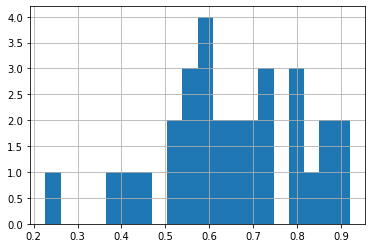

In [155]:
# Sae1 46% to 60% median, lowest except for bad classification cases (805 813) 
# Sae2 65% to 71% median, close to middle not filtered for bad classification cases (805) 

pd.Series(ratios).hist(bins=20)
pd.Series(ratios).median()

# ol dplots

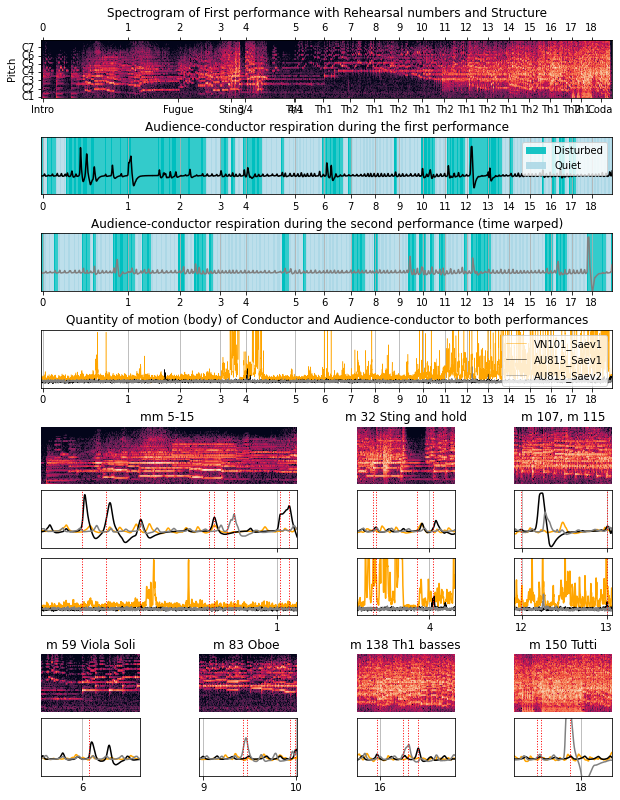

In [115]:
fig3 = plt.figure(constrained_layout=True,figsize=(8.5,11))
gs = fig3.add_gridspec(9, 4)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
axes[1] = fig3.add_subplot(gs[1, :])
axes[2] = fig3.add_subplot(gs[2, :])
axes[3] = fig3.add_subplot(gs[3, :])
axes[4] = fig3.add_subplot(gs[4,:2])
axes[5] = fig3.add_subplot(gs[5,:2])
axes[6] = fig3.add_subplot(gs[6,:2])
axes[7] = fig3.add_subplot(gs[4,2])
axes[8] = fig3.add_subplot(gs[5,2])
axes[9] = fig3.add_subplot(gs[6,2])
axes[10] = fig3.add_subplot(gs[4,3])
axes[11] = fig3.add_subplot(gs[5,3])
axes[12] = fig3.add_subplot(gs[6,3])
axes[13] = fig3.add_subplot(gs[7,0])
axes[14] = fig3.add_subplot(gs[8,0])
axes[15] = fig3.add_subplot(gs[7,1])
axes[16] = fig3.add_subplot(gs[8,1])
axes[17] = fig3.add_subplot(gs[7,2])
axes[18] = fig3.add_subplot(gs[8,2])
axes[19] = fig3.add_subplot(gs[7,3])
axes[20] = fig3.add_subplot(gs[8,3])
# Pstructures 
# Pthemes
# Prehearse

buff=15
resprange = [-7,15]
s_time = -buff #C_times.loc[0,concert]
e_time = dur+buff
ax=axes[1]
ax.set_title('Audience-conductor respiration during the first performance')
df_feats = dfeats['AU815_Saev1'].copy()
Insp_seq = Breathings['AU815_Saev1'].copy()
df_feats.loc[:,'Resp_wave'].plot(c=PartPalette['AU815_Saev1'],linestyle='-',label="",ax = ax)
ax.set_xlim([s_time,e_time])
for cat in respcats: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
ax.legend(loc='upper right') #loc='upper right'
for cat in respcats: #'Vocal?',
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[-1,dur+1],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

ax=axes[0]
ax.set(title='Spectrogram of First performance with Rehearsal numbers and Structure')
chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
# xticks = f(Pstructures.loc[:,'C1_Sae1'])
# xticklabels = Pstructures.loc[:,'Structure']
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel('Pitch')  
ax1 = ax.twiny()
ax1.set_xlim([-1,dur+1])
ax1.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
chart.set_yticks([83,71,59,47,35,23,11])
chart.set_yticklabels(pitchticklabels)
# ax1.set(xticks = Pthemes.loc[:,'C1_Sae1'],xticklabels=Pthemes.loc[:,'Theme'])

ax=axes[2]
ax.set_title('Audience-conductor respiration during the second performance (time warped)')
df_feats = dfeats['AU815_Saev2'].copy()
Insp_seq = Breathings['AU815_Saev2'].copy()
df_feats.loc[:,'Resp_wave'].plot(c=PartPalette['AU815_Saev2'],linestyle='-',label="",ax = ax)
for cat in respcats: 
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
# ax.legend() #loc='upper right'
for cat in respcats:
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[-1,dur+1],yticks=[],xlabel='')
# ax.set(xticks = Pthemes.loc[:,'C1_Sae1'],xticklabels=Pthemes.loc[:,'Theme'])
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

ax=axes[3]
ax.set_title('Quantity of motion (body) of Conductor and Audience-conductor to both performances')
recs = ['VN101_Saev1','AU815_Saev1','AU815_Saev2',]
for rec in recs:
    df_feats = dfeats[rec].copy()
    df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],linewidth=0.5,label = rec,ax = ax)
ax.set(ylim=[0,100],xlim=[-1,dur+1],yticks=[],xlabel='')
# ax.set(xticks = Pstructures.loc[:,'C1_Sae1'],xticklabels=Pstructures.loc[:,'Structure'])
ax.legend(loc='upper right')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

resprange = [-5,12]

intervals={
"mm 5-15 ":[22,73],
"m 32 Sting and hold":[150,170],
"m 107, m 115":[342,362],
"m 59 Viola Soli": [220,240],
"m 83 Oboe ":[288,308],
"m 138 Th1 basses":[407,427],
"m 150 Tutti":[431,451] }

excerpts_Label=list(intervals.keys())
for i in range(3):
    exc = excerpts_Label[i]
    [s_time,e_time] = intervals[exc]
    
    ax = axes[(i*3)+4]
    chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
    ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Audio'
    ax.set_title(exc)

    ax = axes[(i*3)+5]
    for rec in recs:
        df_feats = dfeats[rec].copy()
        df_feats.loc[:,'Resp_wave'].plot(c=PartPalette[rec],label = rec,ax = ax)
    tcue_list = annotations.query('TIME<@e_time and TIME>@s_time').index
    for tcue in annotations.loc[tcue_list,'TIME']:
        ax.plot([tcue, tcue],resprange,linestyle = ':',linewidth=1,color='red')  
    ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Resp'
#     ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[],ylabel='Resp')
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=resprange)
    ax.grid()
    
    ax = axes[(i*3)+6]
    for rec in recs:
        df_feats = dfeats[rec].copy()
        df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],label = rec,ax = ax)
    tcue_list = annotations.query('TIME<@e_time and TIME>@s_time').index
    for tcue in annotations.loc[tcue_list,'TIME']:
        ax.plot([tcue, tcue],[0,100],linestyle = ':',linewidth=1,color='red')  
    ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[],yticklabels=[]) #,ylabel='Resp'
#     ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[],ylabel='Resp')
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=[0,100])
    ax.grid()
    
for i in range(4):
    exc = excerpts_Label[i+3]
    [s_time,e_time] = intervals[exc]
    
    ax = axes[(i*2)+13]
    chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
    ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Audio'
    ax.set_title(exc)

    ax = axes[(i*2)+14]
    for rec in recs:
        df_feats = dfeats[rec].copy()
        df_feats.loc[:,'Resp_wave'].plot(c=PartPalette[rec],label = rec,ax = ax)
    tcue_list = annotations.query('TIME<@e_time and TIME>@s_time').index
    for tcue in annotations.loc[tcue_list,'TIME']:
        ax.plot([tcue, tcue],resprange,linestyle = ':',linewidth=1,color='red')  
    ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[],yticklabels=[]) #,ylabel='Resp'
#     ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[],ylabel='Resp')
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=resprange)
    ax.grid()
    
outplots = './plots/'
figname = '_'.join(['Compound_Excerpts',player,ev['Event']+'_2.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()